# <a id='toc1_'></a>[PyTorch](https://pytorch.org/)    [&#8593;](#toc0_)

![](Pics/torch001.png)

[PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html#)




**Table of contents**<a id='toc0_'></a>    
- [PyTorch   ](#toc1_)    
- [Learn the Basics](#toc2_)    
  - [0. Quickstart](#toc2_1_)    
    - [Working with data](#toc2_1_1_)    
    - [Creating Models](#toc2_1_2_)    
    - [Optimizing the Model Parameters](#toc2_1_3_)    
    - [Saving & Loading Models](#toc2_1_4_)    
  - [1. Tensors](#toc2_2_)    
    - [Tensor Initialization](#toc2_2_1_)    
    - [Tensor Attributes](#toc2_2_2_)    
    - [Tensor Operations](#toc2_2_3_)    
    - [Bridge with NumPy](#toc2_2_4_)    
  - [2. Datasets and DataLoaders](#toc2_3_)    
    - [Loading a Dataset](#toc2_3_1_)    
    - [Iterating and Visualizing the Dataset](#toc2_3_2_)    
    - [Creating a Custom Dataset for your files](#toc2_3_3_)    
    - [Preparing your data for training with DataLoaders](#toc2_3_4_)    
    - [Iterate through the DataLoader](#toc2_3_5_)    
  - [3. Transforms](#toc2_4_)    
  - [4. Build Model](#toc2_5_)    
    - [Get Device for Training](#toc2_5_1_)    
    - [Define the Class](#toc2_5_2_)    
    - [Model Layers](#toc2_5_3_)    
    - [Model Parameters](#toc2_5_4_)    
  - [5. Automatic Differentiation with torch.autograd](#toc2_6_)    
    - [Computing Gradients](#toc2_6_1_)    
    - [Disabling Gradient Tracking](#toc2_6_2_)    
    - [More on Computational Graphs](#toc2_6_3_)    
    - [Optional Reading: Tensor Gradients and Jacobian Products](#toc2_6_4_)    
  - [6. Optimizing Model Parameters](#toc2_7_)    
    - [Hyperparameters](#toc2_7_1_)    
    - [Optimization Loop](#toc2_7_2_)    
    - [Loss Function](#toc2_7_3_)    
    - [Optimizer](#toc2_7_4_)    
    - [Full Implementation](#toc2_7_5_)    
  - [7. Save, Load and Use Model](#toc2_8_)    
    - [Saving and Loading Model Weights](#toc2_8_1_)    
    - [Saving and Loading Models with Shapes](#toc2_8_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Learn the Basics](#toc0_)

[Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)


## <a id='toc2_1_'></a>[0. Quickstart](#toc0_)


### <a id='toc2_1_1_'></a>[Working with data](#toc0_)

PyTorch has two primitives to work with data:
1. torch.utils.data.**DataLoader**  - DataLoader wraps an iterable around the Dataset
2. torch.utils.data.**Dataset**     - Dataset stores the samples and their corresponding labels


In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


PyTorch offers domain-specific libraries - (all of which include datasets)
1. TorchText
2. TorchVision
3. TorchAudio

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO

Full List [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)

Every TorchVision Dataset includes two arguments to modify the samples and labels respectively
1. transform - 用于对样本进行变换
   1. 可以包含多种不同的操作，如缩放、裁剪、归一化等
   2. 目的是通过这些预处理步骤来增强模型的泛化能力或使模型训练更为高效
   3. 可以使用transforms.Compose来组合多个图像变换操作
2. target_transform - 用于对标签进行变换
   1. 如进行编码或转换成某种特定的格式

In [20]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="/home/lzy/Datasets",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="/home/lzy/Datasets",
    train=False,
    download=True,
    transform=ToTensor(),
)


We pass the **Dataset** as an argument to **DataLoader**. 

This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. 

Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [21]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <a id='toc2_1_2_'></a>[Creating Models](#toc0_)

To define a neural network in PyTorch, we **create a class that inherits from nn.Module**
1. define the layers of the network in the **\_\_init\_\_ function**
2. specify how data will pass through the network in the **forward function**

To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [22]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [23]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()  # 确保父类的构造函数也被正确地调用
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # 根据前面的 shape
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### <a id='toc2_1_3_'></a>[Optimizing the Model Parameters](#toc0_)

To train a model, we need a loss function and an optimizer.

优化器 optimizer 在 PyTorch 中用于存储和更新模型的参数

当创建一个优化器实例时，需要将模型参数传递给它，这样优化器就知道它需要优化哪些参数

模型的参数是通过模型的 .parameters() 方法获取的，该方法返回模型所有可训练参数的迭代器

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In a single training loop, the model makes predictions on the training dataset (fed to it in batches)

and backpropagates the prediction error to adjust the model’s parameters

also check the model’s performance against the test dataset to ensure it is learning

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # 构成了计算图的一部分，每个操作都有可能添加新的节点和边到图中。此时，pred 是计算图中的一个节点，它保存了从输入 X 到输出 pred 的整个计算路径。
        loss = loss_fn(pred, y)  # 损失函数接收模型的预测 pred 和真实标签 y 作为输入，计算出一个损失值 loss。
                                 # 这一步将损失值与预测值 pred（以及通过 pred 间接与模型输入 X）联系起来，构成了计算图的最终输出节点。损失值 loss 反映了模型预测和真实标签之间的差异。

        # Backpropagation
        loss.backward()  # 损失函数（loss）和计算图之间的关系是通过模型预测（pred）来建立的
        optimizer.step()  # 更新模型的参数。基于之前计算的梯度，这个步骤会调整模型的参数以最小化损失函数。
        optimizer.zero_grad()  # 清零梯度。因为 PyTorch 默认会累加梯度，如果不手动清零，那么下次调用 .backward() 时，新计算的梯度会和旧的梯度累加起来

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # :>7f 是格式说明符，: 表示开始格式说明符，> 表示右对齐，7f 表示总宽度为7的浮点数，包括小数点和小数部分，确保输出具有一致的宽度，方便阅读。


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # print(pred.argmax(1))
            # print(y)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # 0.1f 表示格式化为浮点数，保留一位小数。
    # 8f 表示格式化为浮点数，保留八位数（总长度）


In [26]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.304997  [   64/60000]
loss: 2.290905  [ 6464/60000]
loss: 2.263885  [12864/60000]
loss: 2.261687  [19264/60000]
loss: 2.255048  [25664/60000]
loss: 2.214998  [32064/60000]
loss: 2.227069  [38464/60000]
loss: 2.192951  [44864/60000]
loss: 2.187172  [51264/60000]
loss: 2.153394  [57664/60000]
tensor([9, 2, 1, 1, 4, 1, 4, 4, 7, 7, 2, 9, 8, 3, 4, 3, 4, 4, 4, 4, 4, 7, 9, 9,
        3, 4, 4, 3, 9, 4, 8, 4, 3, 4, 4, 4, 7, 7, 7, 9, 4, 1, 4, 9, 4, 9, 4, 3,
        4, 4, 2, 2, 7, 2, 4, 2, 4, 4, 4, 0, 7, 9, 8, 9], device='cuda:0')
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0')
tensor([3, 3, 4, 3, 9, 8, 7, 6, 4, 4, 4, 3, 3, 2, 8, 4, 3, 8, 9, 9, 7, 4, 3, 4,
        4, 2, 7, 3, 4, 7, 1, 4, 0, 3, 2, 2, 3, 4, 7, 4, 9, 4, 7, 9, 9, 4, 4, 7,
        7, 4, 9, 2, 4, 2, 7, 4, 

### <a id='toc2_1_4_'></a>[Saving & Loading Models](#toc0_)

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# print(model.state_dict())


Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


## <a id='toc2_2_'></a>[1. Tensors](#toc0_)


Tensors are a specialized data structure that are very similar to arrays and matrices. 

In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to **NumPy’s ndarrays**

except that **tensors can run on GPUs or other hardware accelerators**

In fact, tensors and NumPy arrays **can often share the same underlying memory**, eliminating the need to copy data.

Tensors are also **optimized for automatic differentiation**.


In [31]:
import torch
import numpy as np


### <a id='toc2_2_1_'></a>[Tensor Initialization](#toc0_)

Tensors can be initialized in various ways
1. Directly from data - The **data type is automatically inferred**.
2. From a NumPy array
3. From another tensor
4. With random or constant values:


In [32]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)
print(x_data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)  # 与 np_array 共享空间
# x_np = torch.tensor(np_array)  # 不与 np_array 共享空间
print(x_np)

x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")
x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

shape = (2, 3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)
print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")


tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])
Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.5090, 0.0472],
        [0.3021, 0.5488]]) 

Random Tensor: 
 tensor([[0.2904, 0.1855, 0.9735],
        [0.6025, 0.7251, 0.8648]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### <a id='toc2_2_2_'></a>[Tensor Attributes](#toc0_)

Tensor attributes describe their
1. shape
2. datatype
3. device on which they are stored.

In [3]:
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")
tensor = tensor.to("cuda")
print(f"Device tensor is stored on: {tensor.device}")


Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu
Device tensor is stored on: cuda:0


### <a id='toc2_2_3_'></a>[Tensor Operations](#toc0_)

Over 100 tensor operations, including
1. transposing
2. indexing
3. slicing
4. mathematical operations
5. linear algebra
6. random sampling

Each of them can be run on the GPU (at typically higher speeds than on a CPU)

In [6]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to('cuda')
    print(f"Device tensor is stored on: {tensor.device}")

print(torch.is_tensor(tensor))


Device tensor is stored on: cuda:0
True


In [15]:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [16]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)


tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [17]:
# This computes the element-wise product
print(f"tensor.mul(tensor) \n {tensor.mul(tensor)} \n")
# Alternative syntax:
print(f"tensor * tensor \n {tensor * tensor}")


tensor.mul(tensor) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor * tensor 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [18]:
print(f"tensor.matmul(tensor.T) \n {tensor.matmul(tensor.T)} \n")
# Alternative syntax:
print(f"tensor @ tensor.T \n {tensor @ tensor.T}")


tensor.matmul(tensor.T) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

tensor @ tensor.T 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [19]:
# In-place operations Operations that have a _ suffix are in-place. For example: x.copy_(y), x.t_(), will change x.

print(tensor, "\n")
tensor.add_(5)
print(tensor)


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


### <a id='toc2_2_4_'></a>[Bridge with NumPy](#toc0_)

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.


In [28]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t.add_(1)
print(f"t: {t}")
print(f"n: {n}")


t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [29]:
n = np.ones(5)
t = torch.from_numpy(n)  # 共享空间

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")


t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


In [30]:
n = np.ones(5)
t = torch.tensor(n)  # 不共享空间

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")


t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


## <a id='toc2_3_'></a>[2. Datasets and DataLoaders](#toc0_)

Code for processing data samples can get messy and hard to maintain;

ideally want our **dataset code to be decoupled from our model training code** for better readability and modularity

PyTorch provides two data primitives that allow you to use pre-loaded datasets as well as your own data.
1. torch.utils.data.DataLoader - DataLoader wraps an iterable around the Dataset to enable easy access to the samples
2. torch.utils.data.Dataset - Dataset stores the samples and their corresponding labels

PyTorch domain libraries provide a number of pre-loaded datasets

subclass torch.utils.data.Dataset and implement functions specific to the particular data

They can be used to prototype and benchmark your model
1. [Image Datasets](https://pytorch.org/vision/stable/datasets.html)
2. [Text Datasets](https://pytorch.org/text/stable/datasets.html)
3. [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

### <a id='toc2_3_1_'></a>[Loading a Dataset](#toc0_)

28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
1. **root**             is the path where the train/test data is stored
2. **train**            specifies training or test dataset
3. **download=True**    downloads the data from the internet if it’s not available at root
4. **transform**        and **target_transform** specify the feature and label transformations

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="/home/lzy/Datasets",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="/home/lzy/Datasets",
    train=False,
    download=True,
    transform=ToTensor()
)




In [4]:
print(type(training_data[0]))  # 一个Tensor + 一个label
print([type(i) for i in training_data[0]])
print(torch.is_tensor(training_data[0][0]))  # True


<class 'tuple'>
[<class 'torch.Tensor'>, <class 'int'>]
True


### <a id='toc2_3_2_'></a>[Iterating and Visualizing the Dataset](#toc0_)

We can index Datasets manually like a list: training_data[index].

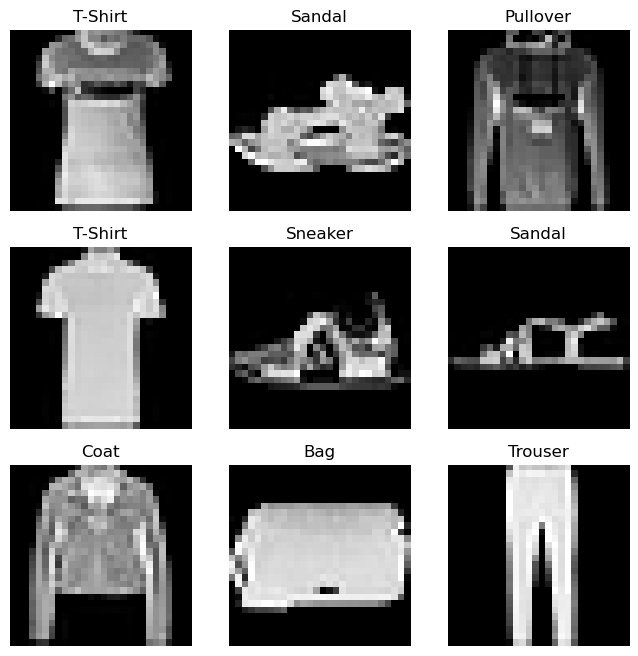

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3  # 定义图形中的子图排列方式
for i in range(1, cols * rows + 1):  # 确保了总共会处理9个元素
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # .item() 方法用于从只包含单个值的tensor中提取这个值并将其转换为一个Python数值
    img, label = training_data[sample_idx]  # 通过随机索引从训练数据集中获取图像和其对应的标签
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    # squeeze() 方法用于去除数组中维度为1的轴
    # cmap 参数代表“colormap”，这个参数决定了如何将数据的数值映射到颜色上。"gray" 表示使用灰度颜色映射，这意味着图像将以灰阶（从黑到白）显示，而不是彩色。
plt.show()


### <a id='toc2_3_3_'></a>[Creating a Custom Dataset for your files](#toc0_)

A custom Dataset class must implement three functions:
1. \_\_init\_\_
   1. run once when instantiating the Dataset object
   2. initialize the directory containing the images, the annotations file, and both transforms
2. \_\_len\_\_
   1. returns the number of samples in our dataset
3. \_\_getitem\_\_
   1. loads and returns a sample from the dataset at the given index idx
   2. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image
   3. retrieves the corresponding label from the csv data in self.img_labels
   4. calls the transform functions on them (if applicable)
   5. returns the tensor image and corresponding label in a tuple






In [6]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


### <a id='toc2_3_4_'></a>[Preparing your data for training with DataLoaders](#toc0_)

The Dataset retrieves our dataset’s features and labels one sample at a time. 

While training a model, we typically want to 
1. pass samples in **minibatches**
2. **reshuffle** the data at every epoch to reduce model overfitting
3. use Python’s **multiprocessing** to speed up data retrieval

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader
from collections.abc import Iterable, Iterator

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8)

print(isinstance(train_dataloader, Iterable))  # 只是   iterable
print(isinstance(train_dataloader, Iterator))  # 还不是 iterator



True
False


### <a id='toc2_3_5_'></a>[Iterate through the DataLoader](#toc0_)

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed.

Each iteration below returns a batch of train_features and train_labels - containing **batch_size**=64 features and labels 

Because we specified **shuffle**=True, after we iterate over all batches the data is shuffled

for finer-grained control over the data loading order, take a look at Samplers

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


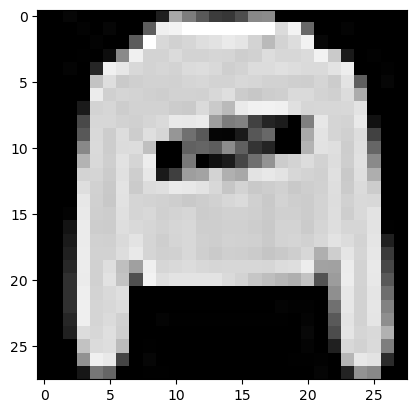

Label: 2


In [30]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")



## <a id='toc2_4_'></a>[3. Transforms](#toc0_)

Data does not always come in its final processed form that is required for training machine learning algorithms

use transforms to perform some manipulation of the data and **make it suitable for training**.

All TorchVision datasets have two parameters that accept callables containing the transformation logic
1. transform to modify the features
2. target_transform to modify the labels

The FashionMNIST features are in PIL Image format, and the labels are integers.

For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.

To make these transformations, we use **ToTensor** and **Lambda**.
1. **ToTensor** converts a PIL image or NumPy ndarray into a **FloatTensor**. and scales the image’s pixel intensity **values in the range [0., 1.]**
2. **Lambda** transforms apply any **user-defined lambda function**. 

In [32]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="/home/lzy/Datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    
    # 从一个整数转换为一个长度为10的独热编码（one-hot encoding）向量
    # dim=0 指定了操作的维度。
    # index=torch.tensor(y) 是一个包含标签整数值的张量，这里 y 就是原始的类别标签。因为FashionMNIST的标签是从0到9的整数，所以这个标签直接用作索引。
    # value=1 指定了要填入的值，即在对应的位置上填入1来完成独热编码。
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # Here, we define a function to turn the integer into a one-hot encoded tensor.
    # It first creates a zero tensor of size 10 (the number of labels in our dataset) 
    # and calls scatter_ which assigns a value=1 on the index as given by the label y.
)

help(torch.Tensor.scatter_)


Help on method_descriptor:

scatter_(...)
    scatter_(dim, index, src, reduce=None) -> Tensor
    
    Writes all values from the tensor :attr:`src` into :attr:`self` at the indices
    specified in the :attr:`index` tensor. For each value in :attr:`src`, its output
    index is specified by its index in :attr:`src` for ``dimension != dim`` and by
    the corresponding value in :attr:`index` for ``dimension = dim``.
    
    For a 3-D tensor, :attr:`self` is updated as::
    
        self[index[i][j][k]][j][k] = src[i][j][k]  # if dim == 0
        self[i][index[i][j][k]][k] = src[i][j][k]  # if dim == 1
        self[i][j][index[i][j][k]] = src[i][j][k]  # if dim == 2
    
    This is the reverse operation of the manner described in :meth:`~Tensor.gather`.
    
    :attr:`self`, :attr:`index` and :attr:`src` (if it is a Tensor) should all have
    the same number of dimensions. It is also required that
    ``index.size(d) <= src.size(d)`` for all dimensions ``d``, and that
    ``index.

In [52]:
import torch
import numpy as np
np_arr = np.zeros(shape=(3,5), dtype=np.uint8)
tensor = torch.from_numpy(np_arr)
index = torch.tensor([1, 0, 3])
print(index)
index.unsqueeze_(1)
print(index)
scatter = tensor.scatter_(dim=1, index=index, value=1)
print(scatter)

print(scatter.max(axis=0))
print(scatter.numpy().max(axis=0))


tensor([1, 0, 3])
tensor([[1],
        [0],
        [3]])
tensor([[0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]], dtype=torch.uint8)
torch.return_types.max(
values=tensor([1, 1, 0, 1, 0], dtype=torch.uint8),
indices=tensor([1, 0, 0, 2, 0]))
[1 1 0 1 0]


## <a id='toc2_5_'></a>[4. Build Model](#toc0_)

Neural networks comprise of layers/modules that perform operations on data.

The **torch.nn** namespace provides all the building blocks you need to build your own neural network.

Every module in PyTorch subclasses the nn.Module.

A neural network is a module itself that consists of other modules (layers).

This nested structure allows for building and managing complex architectures easily.

In [56]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### <a id='toc2_5_1_'></a>[Get Device for Training](#toc0_)

We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available.

Let’s check to see if 
1. torch.cuda
2. torch.backends.mps
are available, otherwise we use the CPU.

In [57]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


### <a id='toc2_5_2_'></a>[Define the Class](#toc0_)

We define our neural network by **subclassing nn.Module**

**initialize** the neural network layers in \_\_init\_\_

Every nn.Module subclass implements the operations on input data in the forward method.

We create an instance of NeuralNetwork, and **move network to the device**, and print its structure.

In [58]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### <a id='toc2_5_3_'></a>[Model Layers](#toc0_)

Model Layers
1. nn.Flatten - convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained)
2. nn.Linear - The linear layer is a module that applies a linear transformation on the input using its stored weights and biases
3. nn.ReLU - applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena
4. nn.Sequential - an ordered container of modules. The data is passed through all the modules in the same order as defined
5. nn.Softmax - scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [66]:
input_image = torch.rand(3,28,28)  # take a sample minibatch of 3 images
print(input_image.size())

flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

print(next(seq_modules.parameters()).device)  # cpu

softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

print(pred_probab)


torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[ 0.4652,  0.4407,  0.0211,  0.0349,  0.1621, -0.3070,  0.0066, -0.0985,
         -0.2506,  0.1627,  0.1045, -0.1476, -0.1657,  0.0459,  0.2580, -0.6443,
          0.2259, -0.3546, -0.0854, -0.2049],
        [ 0.3292, -0.2130,  0.4951,  0.0775,  0.0842, -0.2887, -0.1923, -0.0429,
         -0.0784,  0.3935, -0.2361,  0.2062,  0.3041,  0.0562,  0.1545, -0.8579,
          0.2416, -0.0332,  0.0833,  0.1719],
        [ 0.2518,  0.3768, -0.0082,  0.0089,  0.0050,  0.0620,  0.0788, -0.1955,
         -0.2580,  0.1169,  0.2223, -0.0334, -0.0883, -0.0543,  0.2052, -0.8730,
          0.1431, -0.3235, -0.0437, -0.1123]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4652, 0.4407, 0.0211, 0.0349, 0.1621, 0.0000, 0.0066, 0.0000, 0.0000,
         0.1627, 0.1045, 0.0000, 0.0000, 0.0459, 0.2580, 0.0000, 0.2259, 0.0000,
         0.0000, 0.0000],
        [0.3292, 0.0000, 0.4951, 0.0775, 0.0842, 0.0000, 0.0000, 0.00

### <a id='toc2_5_4_'></a>[Model Parameters](#toc0_)

Many layers inside a neural network are parameterized

have associated weights and biases that are optimized during training

Subclassing nn.Module automatically tracks all fields defined inside your model object

and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

**权重矩阵在左侧，输入数据（向量或矩阵）在右侧**

In [67]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    # 通过 param[:2] 打印出每个参数张量的前两个元素。这里的切片操作 [:2] 旨在提供一个参数值的简略视图


Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0198,  0.0163, -0.0126,  ..., -0.0187, -0.0084, -0.0032],
        [-0.0141,  0.0191,  0.0310,  ...,  0.0097, -0.0032, -0.0313]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0178,  0.0089], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0178,  0.0120,  0.0343,  ..., -0.0363, -0.0290, -0.0281],
        [ 0.0030,  0.0354, -0.0164,  ...,  0.0364, -0.0146, -0.0216]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

In [78]:
x = torch.tensor([[2,0,1],
                  [1,1,1]], dtype=torch.float16)
sf = nn.Softmax(dim=1)
result = sf(x)
print(result)
print(result.sum(dim=1))




tensor([[0.6650, 0.0900, 0.2448],
        [0.3333, 0.3333, 0.3333]], dtype=torch.float16)
tensor([1., 1.], dtype=torch.float16)


## <a id='toc2_6_'></a>[5. Automatic Differentiation with torch.autograd](#toc0_)

When training neural networks, the most frequently used algorithm is **back propagation**.

In this algorithm, **parameters (model weights)** are adjusted according to **the gradient of the loss function** with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called **torch.autograd**.

It supports **automatic computation of gradient for any computational graph**.


In [2]:
import torch

"""
one-layer neural network, with input x, parameters w and b, and some loss function.
"""

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)  # parameter requires_grad
b = torch.randn(3, requires_grad=True)  # parameter requires_grad
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)



In this network, **w and b are parameters**, which we need to optimize. 

Thus, we need to be able to compute the gradients of loss function with respect to those variables. 

In order to do that, we **set the requires_grad property of those tensors**.

You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method.

**computational graph**

![](Pics/torch002.png)

You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method.

A function that we apply to tensors to construct computational graph is in fact an object of class Function.

This object knows how to
1. **compute the function in the forward direction**
2. **compute its derivative during the backward propagation step**.

A reference to the backward propagation function is **stored in grad_fn property of a tensor**.

In [81]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")


Gradient function for z = <AddBackward0 object at 0x7e804309f670>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7e804309e8c0>


### <a id='toc2_6_1_'></a>[Computing Gradients](#toc0_)

To optimize weights of parameters in the neural network, 

we need to compute the derivatives of our loss function with respect to parameters,

namely, we need $\frac{\partial loss}{\partial w}$ and $\frac{\partial loss}{\partial b}$ 

under some fixed values of `x` and `y`. To compute those derivatives, we call `loss.backward()`, 

and then retrieve the values from `w.grad` and `b.grad`:



In [82]:
loss.backward()
print(w.grad)
print(b.grad)


tensor([[0.1638, 0.1752, 0.3123],
        [0.1638, 0.1752, 0.3123],
        [0.1638, 0.1752, 0.3123],
        [0.1638, 0.1752, 0.3123],
        [0.1638, 0.1752, 0.3123]])
tensor([0.1638, 0.1752, 0.3123])


We can only obtain the grad properties for the leaf nodes of the computational graph,

which have **requires_grad** property set to **True**. 

For **all other nodes in our graph**, gradients will **not be available**.

We can only perform gradient calculations using backward once on a given graph, for performance reasons.

If we need to do **several backward calls on the same graph, we need to pass retain_graph=True to the backward call.**


ChatGPT4 解释
1. **只有叶子节点的梯度可获取**
   1. 在 PyTorch 的计算图中，只有被标记为 requires_grad=True 的叶子节点（leaf nodes）的梯度（grad 属性）是可获取的。
   2. 叶子节点通常是指那些直接由用户创建的张量，而不是通过任何操作从其他张量计算得来的张量。
   3. 这是因为只有这些节点代表的张量是需要优化的参数，或者是需要通过梯度信息来更新的数据。
2. **非叶子节点的梯度不可获取**
   1. 对于计算图中的非叶子节点，即那些由其他张量通过操作生成的张量，默认情况下不会保留它们的梯度（grad 属性）。
   2. 这是出于性能和内存使用的考虑。在大多数情况下，我们只关心对模型参数（即叶子节点）的更新，而**不关心中间计算步骤的梯度**。
3. **单次反向传播限制**
   1. 出于性能考虑，**PyTorch 默认允许在给定的计算图上只进行一次反向传播（即调用 .backward() 方法一次）**。
   2. 这是因为**在完成一次反向传播后，PyTorch 会自动清理计算图中的中间结果以节省内存**。
   3. **如果你试图在同一个计算图上再次调用 .backward()，将会抛出错误**。
4. **多次反向传播**
   1. 如果你需要在同一个计算图上进行**多次反向传播，可以在调用 .backward() 时传递参数 retain_graph=True**。
   2. 这样做会让 PyTorch 保留计算图，允许你进行额外的 .backward() 调用。
   3. 但请注意，这**会增加内存的使用**，因为计算图中的中间结果需要被保留。


PyTorch
1. **默认累加梯度**
   1. PyTorch 会默认累加梯度，即每次调用 .backward() 时，计算出的梯度会被加到已有的 .grad 属性上
   2. 如果你不手动清零梯度(optimizer.zero_grad())，那么梯度会在多次反向传播中持续累加。
2. **动态计算图**
   1. PyTorch 使用动态计算图（也称为动态自动微分系统），这意味着图是在运行时即时创建的
   2. 默认情况下，当你对计算图的根节点调用 .backward() 时，PyTorch 会自动计算梯度，并且释放用于梯度计算的中间变量和资源。这意味着计算图被“消耗”了
   3. 想要对同一个计算图多次调用 .backward()，以便从同一个前向传播过程中获取多个不同的梯度计算结果。需要在调用 .backward() 时设置 retain_graph=True




### <a id='toc2_6_2_'></a>[Disabling Gradient Tracking](#toc0_)

By default, all tensors with **requires_grad=True** are **tracking their computational history** and **support gradient computation**.

However, there are some cases when we do not need to do that,

for example, when we have trained the model and **just want to apply it to some input data**, 

we **only want to do forward computations** through the network.

We can stop tracking computations by surrounding our computation code **with torch.no_grad() block**:


In [84]:
z = torch.matmul(x, w)+b
print(z.requires_grad)  # True

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)  # False



True
False


In [85]:
z = torch.matmul(x, w)+b
z_det = z.detach()  # 不改变原来的属性

print(z_det.requires_grad)  # False
print(z.requires_grad)  # True


False
True


There are reasons you might want to disable gradient tracking:
1. To mark some parameters in your neural network as frozen parameters.
2. To speed up computations when you are only doing forward pass, computations that do not track gradients would be more efficient.

### <a id='toc2_6_3_'></a>[More on Computational Graphs](#toc0_)

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG 有向无环图) consisting of Function objects. 

In this DAG, **leaves are the input tensors**, **roots are the output tensors**. By tracing this graph from roots to leaves, you can automatically **compute the gradients using the chain rule**.

In a **forward** pass, autograd does two things simultaneously:
1. run the requested operation to **compute a resulting tensor**
2. **maintain the operation’s gradient function** in the DAG

The **backward** pass kicks off when **.backward()** is called on the DAG root. autograd then:
1. computes the gradients from each **.grad_fn**,
2. **accumulates** them in the respective tensor’s **.grad attribute**
3. using the chain rule, **propagates all the way to the leaf tensors**.

DAGs are **dynamic** in PyTorch An important thing to note is that the graph is recreated from scratch; 

after each **.backward() call**, autograd starts populating a new graph. 

This is exactly what allows you to use control flow statements in your model; 

you can change the shape, size and operations at every iteration if needed.

### <a id='toc2_6_4_'></a>[Optional Reading: Tensor Gradients and Jacobian Products](#toc0_)

For a vector function $\vec{y}=f(\vec{x})$, where

$\vec{x}=\langle x_1,\dots,x_n\rangle$ and

$\vec{y}=\langle y_1,\dots,y_m\rangle$, 

a gradient of $\vec{y}$ with respect to $\vec{x}$ is given by **Jacobian matrix**:

$$\begin{aligned}
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
\end{aligned}$$

Instead of computing the Jacobian matrix itself, 

PyTorch allows you to compute **Jacobian Product** $v^T\cdot J$ for a given input vector $v=(v_1 \dots v_m)$.

This is achieved by calling `backward` with $v$ as an argument. 

The size of $v$ should be the same as the size of the original tensor, with respect to which we want to compute the product:






In [5]:
import torch

inp = torch.eye(4, 5, requires_grad=True)
print(f"input\n{inp}")
out = (inp+1).pow(2).t()

out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")

out.backward(torch.ones_like(out), retain_graph=True)  # backward默认累加梯度
print(f"\nSecond call\n{inp.grad}")

inp.grad.zero_()  # 在归零梯度后，梯度的计算重新开始，之前累积的梯度不再有影响
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")


input
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)
First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


默认情况下，调用 .backward() 后，PyTorch 会自动清除计算图以节省内存。

对于更复杂的情况，比如当损失是一个向量而不是标量时，你需要传递一个**梯度张量**作为参数

Previously we were calling backward() function without parameters

This is essentially **equivalent to calling backward(torch.tensor(1.0))**

which is a useful way to compute the gradients in case of a scalar-valued function

such as loss during neural network training.

## <a id='toc2_7_'></a>[6. Optimizing Model Parameters](#toc0_)

Now that we have a model and data it’s time to **train, validate and test** our model by optimizing its parameters on our data. 

Training a model is an **iterative process**, in each iteration
1. the model makes a guess about the output
2. calculates the error in its guess (loss)
3. collects the derivatives of the error with respect to its parameters (as we saw in the previous section)
4. optimizes these parameters using gradient descent. 

[反向传播演算|附录深入学习第3章 - 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8)


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root = "/home/lzy/Datasets",
    train = True,
    download= True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "/home/lzy/Datasets",
    train = False,
    download= True,
    transform=ToTensor()
)

train_dataloader = DataLoader(dataset=training_data, batch_size=64)
test_dataloader = DataLoader(dataset=test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()


### <a id='toc2_7_1_'></a>[Hyperparameters](#toc0_)

Hyperparameters are **adjustable parameters** that let you **control the model optimization process**. 

Different hyperparameter values can **impact model training** and **convergence rates**收敛

We define the following hyperparameters for training:
1. **Number of Epochs** - the number times to iterate over the dataset
2. **Batch Size** - **the number of data samples propagated** through the network before the parameters are updated
3. **Learning Rate** - **how much to update models parameters** at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [2]:
learning_rate = 1e-3
batch_size = 64
epochs = 5


### <a id='toc2_7_2_'></a>[Optimization Loop](#toc0_)

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop.

Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
1. **Train Loop** - iterate over the **training dataset** and try to **converge to optimal parameters**.
2. **Validation/Test Loop** - iterate over the **test dataset** to **check if model performance is improving**.


### <a id='toc2_7_3_'></a>[Loss Function](#toc0_)

When presented with some training data, our untrained network is likely not to give the correct answer.

**Loss function measures the degree of dissimilarity of obtained result to the target value**

and it is the loss function that we **want to minimize** during training.

To calculate the loss we **make a prediction using the inputs of our given data sample and compare it against the true data label value**.

Common loss functions include
1. nn.**MSELoss** (Mean Square Error) for regression tasks
2. nn.**NLLLoss** (Negative Log Likelihood) for classification
3. nn.**CrossEntropyLoss** combines nn.**LogSoftmax** and nn.**NLLLoss**.

We pass our model’s output logits to nn.**CrossEntropyLoss**, which will normalize the logits and compute the prediction error.

In [3]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# 测试使用
import numpy as np
print(loss_fn(torch.tensor([[1,2,3]], dtype=torch.float32),torch.tensor([1], dtype=torch.int64)))


tensor(1.4076)


### <a id='toc2_7_4_'></a>[Optimizer](#toc0_)

Optimization is the process of **adjusting model parameters** to **reduce model error** in each training step.

**Optimization algorithms** define how this process is **performed** (in this example we use Stochastic Gradient Descent(SGD)).

**All optimization logic is encapsulated in the optimizer object**. Here, we use the SGD optimizer;

additionally, there are many different optimizers available in PyTorch such as **ADAM** and **RMSProp**, that work better for different kinds of models and data.

We **initialize the optimizer by registering the model’s parameters that need to be trained**, and **passing in the learning rate** hyperparameter.


In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


Inside the training loop, optimization happens in three steps:
1. Call **optimizer.zero_grad()** to reset the gradients of model parameters. **Gradients by default add up**; to **prevent double-counting**, we **explicitly zero them at each iteration**.
2. Backpropagate the prediction loss with a call to **loss.backward()**. PyTorch deposits the gradients of the loss w.r.t. each parameter.
3. Once we have our gradients, we call **optimizer.step()** to **adjust the parameters by the gradients collected in the backward pass**.

### <a id='toc2_7_5_'></a>[Full Implementation](#toc0_)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.302390  [   64/60000]


loss: 2.287064  [ 6464/60000]
loss: 2.257724  [12864/60000]
loss: 2.250964  [19264/60000]
loss: 2.245654  [25664/60000]
loss: 2.202785  [32064/60000]
loss: 2.220617  [38464/60000]
loss: 2.180820  [44864/60000]
loss: 2.179023  [51264/60000]
loss: 2.132547  [57664/60000]
Test Error: 
 Accuracy: 42.1%, Avg loss: 2.132376 

Epoch 2
-------------------------------
loss: 2.154032  [   64/60000]
loss: 2.135489  [ 6464/60000]
loss: 2.063765  [12864/60000]
loss: 2.081374  [19264/60000]
loss: 2.035579  [25664/60000]
loss: 1.968050  [32064/60000]
loss: 1.999760  [38464/60000]
loss: 1.915042  [44864/60000]
loss: 1.917457  [51264/60000]
loss: 1.832056  [57664/60000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.835503 

Epoch 3
-------------------------------
loss: 1.881089  [   64/60000]
loss: 1.840010  [ 6464/60000]
loss: 1.708825  [12864/60000]
loss: 1.751910  [19264/60000]
loss: 1.648588  [25664/60000]
loss: 1.602713  [32064/60000]
loss: 1.622786  [38464/60000]
loss: 1.528808  [44864/60000]
loss: 

In [13]:
from torch.optim.lr_scheduler import StepLR

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.398624  [   64/60000]
loss: 0.514508  [ 6464/60000]
loss: 0.332341  [12864/60000]
loss: 0.545603  [19264/60000]
loss: 0.496473  [25664/60000]
loss: 0.500548  [32064/60000]
loss: 0.503307  [38464/60000]
loss: 0.667397  [44864/60000]
loss: 0.625670  [51264/60000]
loss: 0.455581  [57664/60000]
Current Learning Rate: 0.001


Test Error: 
 Accuracy: 82.0%, Avg loss: 0.507583 

Epoch 2
-------------------------------
loss: 0.394003  [   64/60000]
loss: 0.511513  [ 6464/60000]
loss: 0.329567  [12864/60000]
loss: 0.541506  [19264/60000]
loss: 0.493694  [25664/60000]
loss: 0.498913  [32064/60000]
loss: 0.500327  [38464/60000]
loss: 0.668430  [44864/60000]
loss: 0.624071  [51264/60000]
loss: 0.452259  [57664/60000]
Current Learning Rate: 0.0008
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.505533 

Epoch 3
-------------------------------
loss: 0.390458  [   64/60000]
loss: 0.509487  [ 6464/60000]
loss: 0.327486  [12864/60000]
loss: 0.538369  [19264/60000]
loss: 0.491414  [25664/60000]
loss: 0.497682  [32064/60000]
loss: 0.497974  [38464/60000]
loss: 0.669229  [44864/60000]
loss: 0.622713  [51264/60000]
loss: 0.449791  [57664/60000]
Current Learning Rate: 0.00064
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.503955 

Epoch 4
-------------------------------
loss: 0.387722  [   64/60000]
loss: 0.508111  [ 6464/60000]
los

## <a id='toc2_8_'></a>[7. Save, Load and Use Model](#toc0_)

In [14]:
import torch
import torchvision.models as models


### <a id='toc2_8_1_'></a>[Saving and Loading Model Weights](#toc0_)

PyTorch models **store the learned parameters in an internal state dictionary**, called **state_dict**.

These can be persisted via the torch.save method:

be sure to **call model.eval() method before inferencing** to **set the dropout and batch normalization layers to evaluation mode**.
1. 确保 Dropout 层被禁用，所有神经元都处于激活状态。
2. 确保 Batch Normalization 层使用这些训练期间计算得到的参数进行归一化，而不是当前输入批次的统计量

Failing to do this will **yield inconsistent inference results.**


In [15]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')


model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/lzy/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:48<00:00, 11.5MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### <a id='toc2_8_2_'></a>[Saving and Loading Models with Shapes](#toc0_)

When loading model weights, we needed to **instantiate the model class** first, because the **class defines the structure of a network**. 

We might want to **save the structure of this class together with the model**, 

in which case we can pass model (and not model.state_dict()) to the saving function


In [ ]:
torch.save(model, 'model.pth')
model = torch.load('model.pth')


This approach uses **Python pickle module** when serializing the model, 

thus it **relies on the actual class definition to be available** when loading the model.